In [3]:
import os, sys
import re
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

plt.rcParams.update({'font.size': 14})

In [4]:
testname_re = re.compile("test_(\d+)-(\d+).py")

In [5]:
testsuiteNameCache = {}
def getTestsuiteNameFromFile(file):
    global testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/")
    s = file.replace("-","/").split("/")
    cur_test = s[-3]+"/"+s[-2]
    with open(file, "r") as f:
        for line in f:
            if line.startswith("###### Description ######"):
                testsuite_name = (f.readline()).strip("#\ \n")
                testsuiteNameCache[cur_test] = testsuite_name
                return testsuite_name
            
def getTestsuiteName(file):
    global testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/")
    s = file.replace("-","/").split("/")
    cur_test = s[-3]+"/"+s[-2]
    return testsuiteNameCache[cur_test]

In [8]:
args = type('', (), {})
args.data = "time"

In [9]:
def getData(raw_results):
    result_dict = {}
    for cur_pickle in raw_results["pickleSuites"]:
        result_dict[cur_pickle] = {}
        # First loop to init the dict with testsuite name
        for cur_file in raw_results[cur_pickle]:
            if cur_file.endswith("-1.py"):
                cur_testname = getTestsuiteNameFromFile(cur_file)
                if cur_testname in result_dict[cur_pickle]:
                    raise Exception("Impossible flow") # Only one init file should exist.
                result_dict[cur_pickle][cur_testname] = [{} for i in range(2)] # 0/1 for init/test
        # Add the result to our result_dict
        for cur_file in raw_results[cur_pickle]:
            # Get args.data (default: "result") from raw_result
            results = {k: raw_results[cur_pickle][cur_file][k][args.data] if args.data in raw_results[cur_pickle][cur_file][k] else "NA" for k in raw_results[cur_pickle][cur_file]}
            if cur_file.endswith("-1.py"):
                result_dict[cur_pickle][getTestsuiteName(cur_file)][0] = results
            else:
                # There may be several test file
                result_dict[cur_pickle][getTestsuiteName(cur_file)][1].update(results)
                
    # Beauty print with pandas
    all_results = {}
    for testsuite in result_dict[list(result_dict.keys())[0]]:
        df_all_pickles = []
        for cur_pickle in result_dict:
            df = pd.DataFrame(data=result_dict[cur_pickle][testsuite])
            df = df.fillna(' ').T
            df = df.rename(columns={0: "Init(%s)" % (cur_pickle), 1: "Test(%s)" % (cur_pickle)})
            df_all_pickles.append(df)
        result = pd.concat(df_all_pickles, axis=1)
        all_results[testsuite] = result
    return all_results

In [10]:
result_file = "cloudpickle.json"
with open(result_file, "r") as f:
    raw_results = json.load(f)
all_cloudpickle_results = getData(raw_results)

result_file = "codepickle.json"
with open(result_file, "r") as f:
    raw_results = json.load(f)
all_codepickle_results = getData(raw_results)

In [11]:
# For exec
exec_testsuiteNameCache = {}
def exec_getTestsuiteNameFromFile(file):
    global exec_testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/")
    with open(file, "r") as f:
        for line in f:
            if line.startswith("###### Description ######"):
                testsuite_name = (f.readline()).strip("#\ \n")
                exec_testsuiteNameCache[file] = testsuite_name
                return testsuite_name
            
def exec_getTestsuiteName(file):
    global exec_testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/")
    return exec_testsuiteNameCache[file]

In [19]:
# Load from exec results
def getData_exec(exec_raw_results):
    cur_pickle = "exec"
    exec_result_dict = {}
    exec_result_dict[cur_pickle] = {}
    # First loop to init the dict with testsuite name
    for cur_file in exec_raw_results[cur_pickle]:
        cur_testname = exec_getTestsuiteNameFromFile(cur_file)
        exec_result_dict[cur_pickle][cur_testname] = [{} for i in range(2)] # 0/1 for init/test
    # Add the result to our result_dict
    for cur_file in exec_raw_results[cur_pickle]:
        # Get args.data (default: "result") from raw_result
        results = {k: exec_raw_results[cur_pickle][cur_file][k][args.data] if args.data in exec_raw_results[cur_pickle][cur_file][k] else "NA" for k in exec_raw_results[cur_pickle][cur_file]}
        # For exec, there should be only Test, no init.
        exec_result_dict[cur_pickle][exec_getTestsuiteName(cur_file)][1] = results

    exec_all_results = {}
    for testsuite in exec_result_dict[list(exec_result_dict.keys())[0]]:
        df_all_pickles = []
        for cur_pickle in exec_result_dict:
            df = pd.DataFrame(data=exec_result_dict[cur_pickle][testsuite])
            df = df.fillna(' ').T
            df = df.rename(columns={0: "Init(%s)" % (cur_pickle), 1: "Test(%s)" % (cur_pickle)})
            df_all_pickles.append(df)
        result = pd.concat(df_all_pickles, axis=1)
        exec_all_results[testsuite] = result
    return exec_all_results

In [20]:
exec_result_file = "exec.json"
with open(exec_result_file, "r") as f:
    exec_raw_results = json.load(f)
all_exec_results = getData_exec(exec_raw_results)

exec_result_file = "pyodide.json"
with open(exec_result_file, "r") as f:
    exec_raw_results = json.load(f)
all_pyodide_results = getData_exec(exec_raw_results)

In [21]:
# List all testsuite
for ts in all_codepickle_results:
    print(ts)
    for test in all_codepickle_results[ts].index:
        print("    %s" % test)

Closure
    test_func_closure
Recursive_function
    test_func_recursive
    test_func_recursive_double
Function_scope
    test_func_shared_scope
Functions
    test_func_chain
    test_func_simple
    test_func_simple_with_default_arg
Modules
    test_module_alias
    test_module_closure
    test_module_simple
Classes
    test_class_nested
    test_class_object
    test_class_simple
Inherit_class
    test_class_inherit
    test_class_inherit_instance
Distributed_sort
    test_distributed_sort


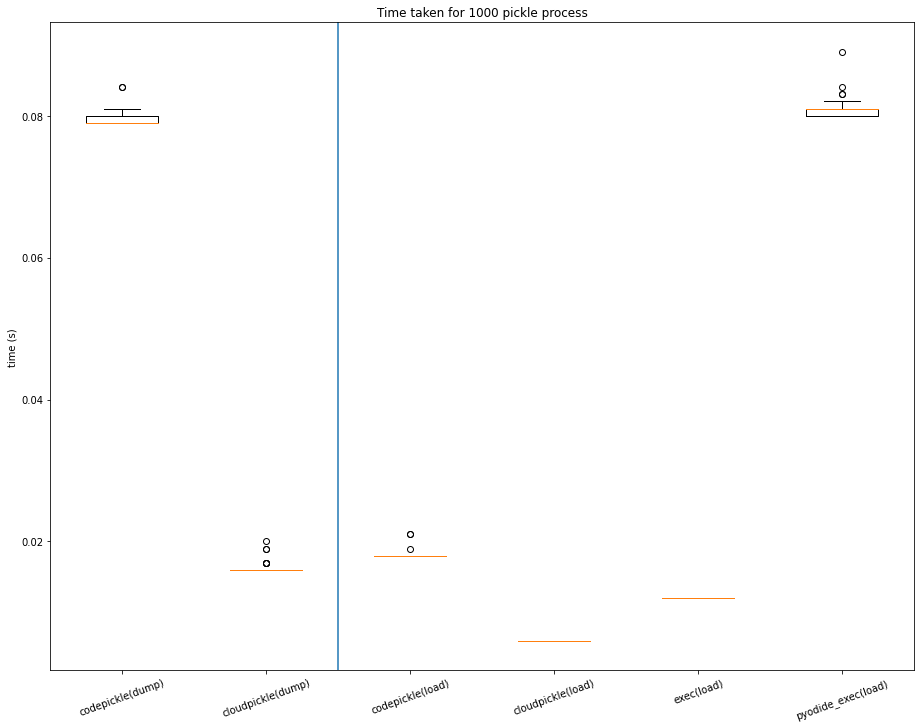

In [23]:
data = []
data.append(all_codepickle_results["Functions"]["Init(cloudpickle)"]["test_func_simple"])
data.append(all_cloudpickle_results["Functions"]["Init(cloudpickle)"]["test_func_simple"])
data.append(all_codepickle_results["Functions"]["Test(cloudpickle)"]["test_func_simple"])
data.append(all_cloudpickle_results["Functions"]["Test(cloudpickle)"]["test_func_simple"])
data.append(all_exec_results["Functions"]["Test(exec)"]["test_func_simple"])
data.append(all_pyodide_results["Functions"]["Test(exec)"]["test_func_simple"])

fig = plt.figure(figsize =(12, 9))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_title('Time taken for 1000 pickle process')
xtick = ["codepickle(dump)", "cloudpickle(dump)", "codepickle(load)", "cloudpickle(load)", "exec(load)", "pyodide_exec(load)"]
ax.set_xticks(range(1,1+len(xtick)), xtick, rotation=20)
ax.set_ylabel('time (s)')
plt.axvline(x=2.5)
fig.show()

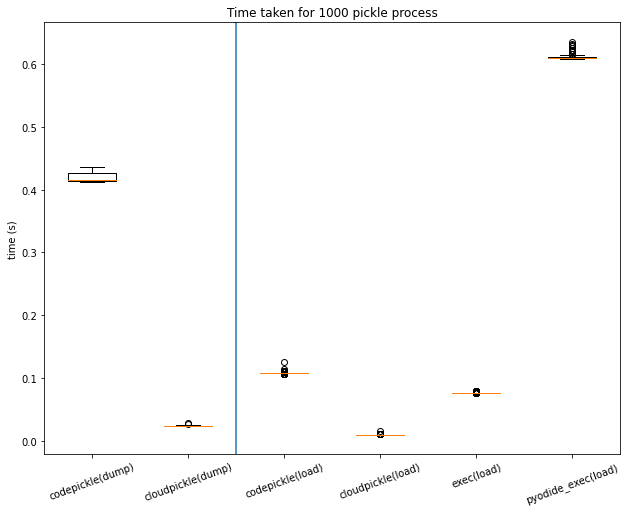

In [24]:
data = []
data.append(all_codepickle_results["Distributed_sort"]["Init(cloudpickle)"]["test_distributed_sort"])
data.append(all_cloudpickle_results["Distributed_sort"]["Init(cloudpickle)"]["test_distributed_sort"])
data.append(all_codepickle_results["Distributed_sort"]["Test(cloudpickle)"]["test_distributed_sort"])
data.append(all_cloudpickle_results["Distributed_sort"]["Test(cloudpickle)"]["test_distributed_sort"])
data.append(all_exec_results["Distributed_sort"]["Test(exec)"]["test_distributed_sort"])
data.append(all_pyodide_results["Distributed_sort"]["Test(exec)"]["test_distributed_sort"])

fig = plt.figure(figsize =(8, 6))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_title('Time taken for 1000 pickle process')
xtick = ["codepickle(dump)", "cloudpickle(dump)", "codepickle(load)", "cloudpickle(load)", "exec(load)", "pyodide_exec(load)"]
ax.set_xticks(range(1,1+len(xtick)), xtick, rotation=20)
ax.set_ylabel('time (s)')
plt.axvline(x=2.5)
fig.show()

In [25]:
# List all testsuite
for testsuite in all_codepickle_results:
    print(testsuite)
    for test in all_codepickle_results[testsuite].index:
        print("  %s" % (test))
        print("    Init(codepickle): %.3f" % np.mean(all_codepickle_results[testsuite]["Init(cloudpickle)"][test]))
        print("    Init(cloudpickle): %.3f" % np.mean(all_cloudpickle_results[testsuite]["Init(cloudpickle)"][test]))
        print("    Test(codepickle): %.3f" % np.mean(all_codepickle_results[testsuite]["Test(cloudpickle)"][test]))
        print("    Test(cloudpickle): %.3f" % np.mean(all_cloudpickle_results[testsuite]["Test(cloudpickle)"][test]))
        if all_exec_results[testsuite]["Test(exec)"][test] == "NA":
            print("    Test(exec): -")
        else:
            print("    Test(exec): %.3f" % np.mean(all_exec_results[testsuite]["Test(exec)"][test]))
        if all_pyodide_results[testsuite]["Test(exec)"][test] == "NA":
            print("    Test(pyodide): -")
        else:
            print("    Test(pyodide): %.3f" % np.mean(all_pyodide_results[testsuite]["Test(exec)"][test]))

Closure
  test_func_closure
    Init(codepickle): 0.086
    Init(cloudpickle): 0.024
    Test(codepickle): 0.019
    Test(cloudpickle): 0.008
    Test(exec): 0.018
    Test(pyodide): 0.118
Recursive_function
  test_func_recursive
    Init(codepickle): 0.110
    Init(cloudpickle): 0.016
    Test(codepickle): 0.024
    Test(cloudpickle): 0.006
    Test(exec): 0.017
    Test(pyodide): 0.138
  test_func_recursive_double
    Init(codepickle): 0.202
    Init(cloudpickle): 0.022
    Test(codepickle): 0.046
    Test(cloudpickle): 0.009
    Test(exec): 0.030
    Test(pyodide): 0.249
Function_scope
  test_func_shared_scope
    Init(codepickle): 0.170
    Init(cloudpickle): 0.022
    Test(codepickle): 0.038
    Test(cloudpickle): 0.008
    Test(exec): 0.023
    Test(pyodide): 0.197
Functions
  test_func_chain
    Init(codepickle): 0.173
    Init(cloudpickle): 0.024
    Test(codepickle): 0.047
    Test(cloudpickle): 0.010
    Test(exec): 0.030
    Test(pyodide): 0.215
  test_func_simple
    Init(c